In [ ]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.utils import resample
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import os


from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler


import numpy as np
import pandas as pd
from sklearn.preprocessing import FunctionTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score


import numpy as np
from sklearn.preprocessing import FunctionTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score

from sklearn.ensemble import VotingClassifier, StackingClassifier


# Import dataset

In [119]:
data_path = 'creditcard.csv' 
df = pd.read_csv(data_path)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Explore dataset

Checking some basic things:
- if there are nulls,
- if there any interesting correlations between variables

In [24]:
# all the variables are numeric, no need to worry about preprocessing categorical vars
# no need to worry about nulls (some algoritms dont tolerate them)
# good number of records
# time and amount variables are the only variables not encrypted

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [25]:
# dont see much here, but since these are numeric, let´s plot some correlations and cehck distributions of variables

df.describe().round(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,...,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,...,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,...,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,...,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


array([[<Axes: title={'center': 'Time'}>, <Axes: title={'center': 'V1'}>,
        <Axes: title={'center': 'V2'}>, <Axes: title={'center': 'V3'}>,
        <Axes: title={'center': 'V4'}>, <Axes: title={'center': 'V5'}>],
       [<Axes: title={'center': 'V6'}>, <Axes: title={'center': 'V7'}>,
        <Axes: title={'center': 'V8'}>, <Axes: title={'center': 'V9'}>,
        <Axes: title={'center': 'V10'}>, <Axes: title={'center': 'V11'}>],
       [<Axes: title={'center': 'V12'}>, <Axes: title={'center': 'V13'}>,
        <Axes: title={'center': 'V14'}>, <Axes: title={'center': 'V15'}>,
        <Axes: title={'center': 'V16'}>, <Axes: title={'center': 'V17'}>],
       [<Axes: title={'center': 'V18'}>, <Axes: title={'center': 'V19'}>,
        <Axes: title={'center': 'V20'}>, <Axes: title={'center': 'V21'}>,
        <Axes: title={'center': 'V22'}>, <Axes: title={'center': 'V23'}>],
       [<Axes: title={'center': 'V24'}>, <Axes: title={'center': 'V25'}>,
        <Axes: title={'center': 'V26'}>, <

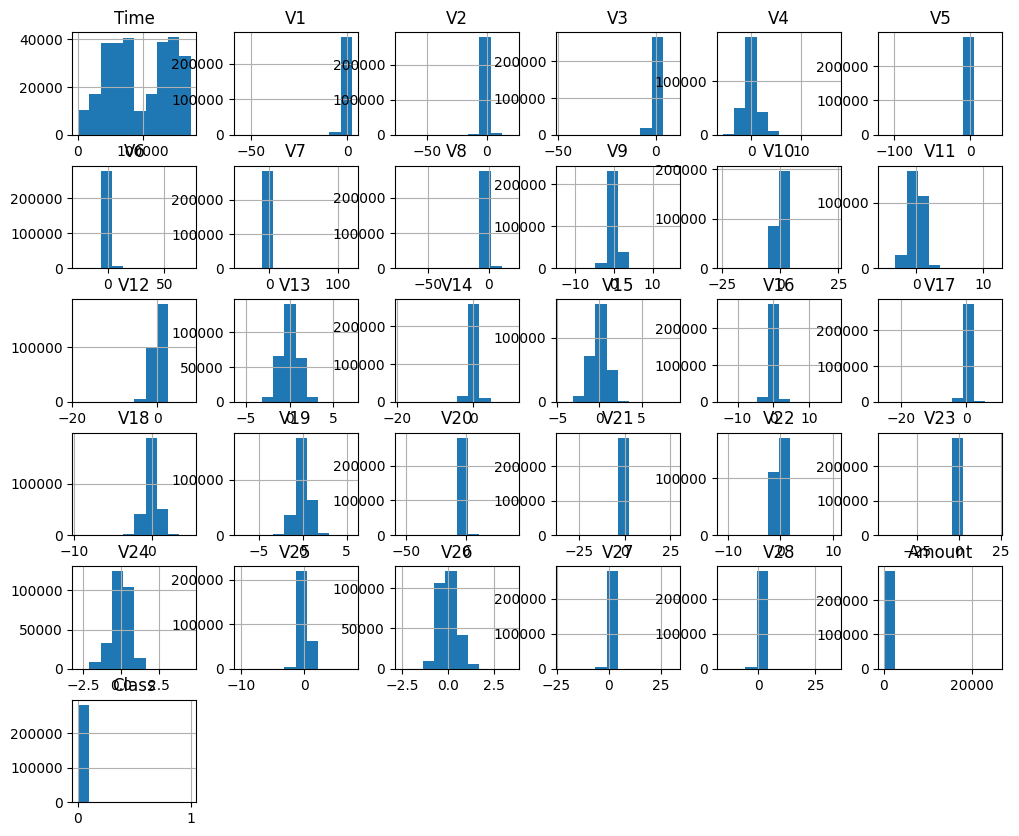

In [26]:
df.hist(figsize=(12, 10))

# time is bimodal
# here I see that some variables are skewed or have outliers; anomalies are likely signals of fraud

# not sure though what I can do about any of those distributions; further I will be tranforming them with StandardScaler

In [102]:
# the dataset is imbalanced

df['Class'].value_counts(normalize = True)

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

/var/folders/6t/ss4jn8_x3bx5gzn4fh3r10g00000gn/T/ipykernel_77767/2032563797.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('time_bin')['Class'].mean().reset_index().plot(
/var/folders/6t/ss4jn8_x3bx5gzn4fh3r10g00000gn/T/ipykernel_77767/2032563797.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[df['Class'] == 1].groupby('time_bin')['Class'].count().reset_index().plot(


<Axes: title={'center': 'Fraud Rate (count) Over Time'}, xlabel='time_bin'>

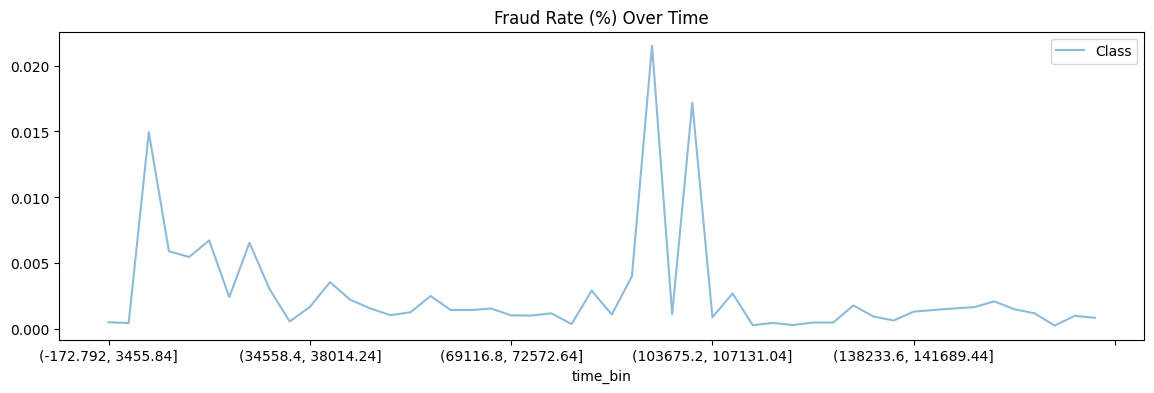

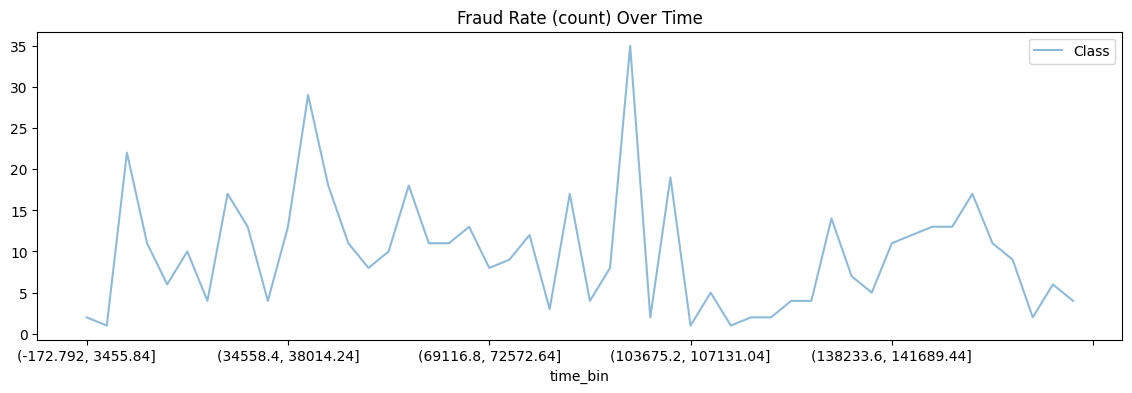

In [113]:
df['time_bin'] = pd.cut(df['Time'], bins=50)


df.groupby('time_bin')['Class'].mean().reset_index().plot(
    x='time_bin', y='Class', kind='line', figsize=(14, 4), alpha=0.5, title='Fraud Rate (%) Over Time'
)

df[df['Class'] == 1].groupby('time_bin')['Class'].count().reset_index().plot(
    x='time_bin', y='Class', kind='line', figsize=(14, 4), alpha=0.5, title='Fraud Rate (count) Over Time'
)

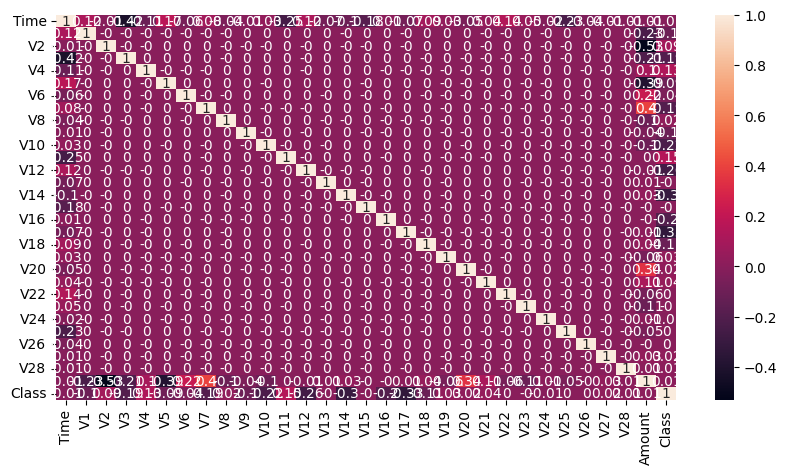

In [88]:
# let´s check if there are any features that are highly correlated
# looks like there are no particularly strong correlations between variables

corr_matrix = df.corr().round(2)

plt.figure(figsize = (10,5))
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [106]:
df_downasampled = pd.concat([df[df['Class'] == 0].sample(492,random_state=42), df[df['Class'] == 1]])
df_downasampled['Class'].value_counts()

Class
0    492
1    492
Name: count, dtype: int64

In [110]:
df_downasampled = df_downasampled.drop('time_bin', axis=1)

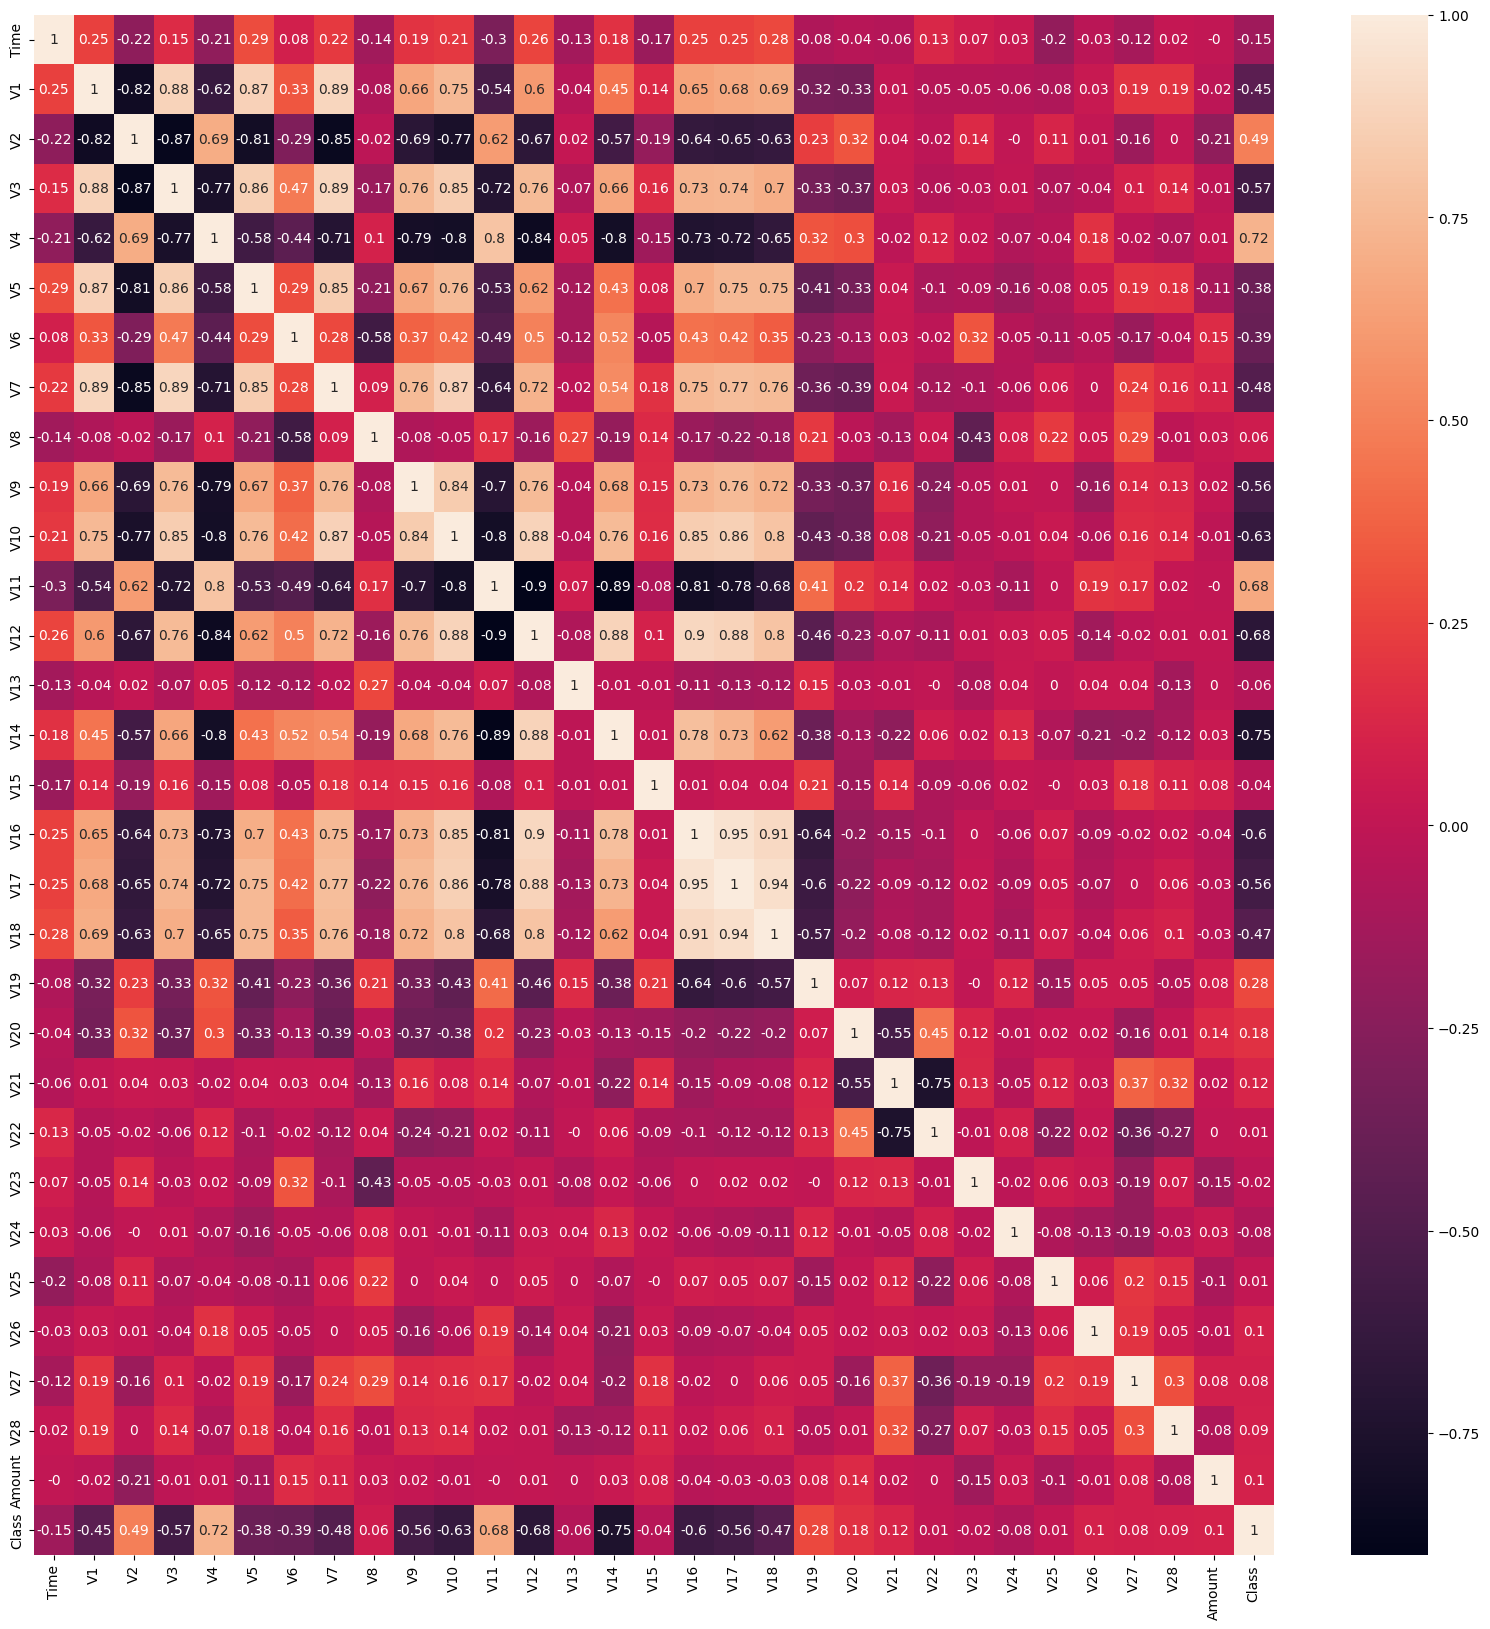

In [ ]:
# having downsampled the dataset, we can better see the correlation between features because fraud cases are more visible
# we will only use downsampling for analysis, not for modeling

corr_matrix = df_downasampled.corr().round(2)

plt.figure(figsize = (20,20))
sns.heatmap(corr_matrix, annot=True)
plt.show()

# Conclusions:
## Features with highest positive corr to fraud are 2, 4, 11, 19
## Features with highest negative corr to fraud are 3, 9, 10, 12, 14, 17, 18, 20

Correlation might not be the best when we have a binary variable and continuous feature. Let´s try doing t-test


In [114]:
not_fraud = df_downasampled[df_downasampled['Class'] == 0]
fraud = df_downasampled[df_downasampled['Class'] == 1]

train_cols = [col for col in df_downasampled.columns if col != 'Class'] # choosing all continuous columns except target

# Run t-test for each feature

p_values = []

for c in train_cols:
    p = ttest_ind(not_fraud[c], fraud[c]).pvalue
    p_values.append({'variable': c, 'p_value': p})

p_values_df = pd.DataFrame(p_values)
p_values_df

,variable,p_value
0,Time,2.625793e-06
1,V1,2.665543e-49
2,V2,2.833511e-61
3,V3,1.478420e-84
4,V4,4.644042e-156
5,V5,7.427613e-35
6,V6,3.972689e-37
7,V7,4.581319e-57
8,V8,7.470631e-02
9,V9,6.356286e-83


In [ ]:
# ok, here I treid to exclude the variables that we not relevant but seems like every variable is valuable here

relevant_p_values = p_values_df[p_values_df['p_value']< 0.05]

relevant_p_values

,variable,p_value
0,Time,2.625793e-06
1,V1,2.665543e-49
2,V2,2.833511e-61
3,V3,1.478420e-84
4,V4,4.644042e-156
5,V5,7.427613e-35
6,V6,3.972689e-37
7,V7,4.581319e-57
9,V9,6.356286e-83
10,V10,7.210768e-109


# Modeling

First lets try a simple model (Logistic Regression) and let it handle the imbalanced class

In [120]:
# split target and features

# sorting df by time to later apply TimeSeries CV
df = df.sort_values(by='Time')


X = df.drop(['Time','Class'], axis=1)  # features
y = df["Class"]               # target

# split into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.25, random_state=42)

#check sample size

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape )

(213605, 29) (71202, 29) (213605,) (71202,)


In [121]:
# With StandardScaler we need to bring different numerical variables to comparable scales before ingesting it into the model

std = StandardScaler()
std = std.fit(X_train)

X_train = std.transform(X_train)
X_test = std.transform(X_test)

Logistic Regression

In [122]:
# here we´ll initialize the Time Serires Cross Validation

tscv = TimeSeriesSplit(n_splits=10)
filtered_splits = []

for i, (train_idx, val_idx) in enumerate(tscv.split(X_train), start=1):
    y_val = y_train.iloc[val_idx]
    positives = (y_val == 1).sum()
    
    if positives > 0:
        filtered_splits.append((train_idx, val_idx))
        print(f"✅ Fold {i} kept: Positives = {positives}")
    else:
        print(f"❌ Fold {i} skipped: Positives = {positives}")


✅ Fold 1 kept: Positives = 18
✅ Fold 2 kept: Positives = 57
✅ Fold 3 kept: Positives = 30
✅ Fold 4 kept: Positives = 32
✅ Fold 5 kept: Positives = 22
✅ Fold 6 kept: Positives = 19
✅ Fold 7 kept: Positives = 87
✅ Fold 8 kept: Positives = 11
✅ Fold 9 kept: Positives = 20
✅ Fold 10 kept: Positives = 17


Logistic Regression with Grid search

In [123]:

pipe = Pipeline([
    ('ros', RandomOverSampler(random_state=42)),
    ('clf', LogisticRegression(max_iter=1000))
])

param_grid = {'clf__C':[0.001,0.01,0.1],'clf__class_weight':[None,'balanced']}
search_lr = GridSearchCV(pipe, param_grid, cv=filtered_splits, scoring='average_precision', n_jobs=-1)
search_lr.fit(X_train, y_train)

# Best parameters and best score
print("Best PR AUC (mean CV):", search_lr.best_score_)
print("Best parameters:", search_lr.best_params_)

# Average precision on the full training set with the best model
y_proba = search_lr.best_estimator_.predict_proba(X_train)[:, 1]
pr_auc_full = average_precision_score(y_train, y_proba)
print("PR AUC on full training set:", pr_auc_full)


Best PR AUC (mean CV): 0.7121951257219565
Best parameters: {'clf__C': 0.01, 'clf__class_weight': None}
PR AUC on full training set: 0.7375715486698476


Random Forest with Grid Search

In [124]:
pipe = Pipeline([
    ('ros', RandomOverSampler(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42))
])

param_grid = {
    'clf__n_estimators': [100, 300],
    'clf__max_depth': [5, 7],
    'clf__max_features': ['sqrt'],
    'clf__criterion': ['gini']
}

search_rf = GridSearchCV(
    pipe, param_grid, cv=filtered_splits,
    scoring='average_precision', n_jobs=-1
)
search_rf.fit(X_train, y_train)

print("Best PR AUC (mean CV):", search_rf.best_score_)
print("Best parameters:", search_rf.best_params_)

y_proba = search_rf.best_estimator_.predict_proba(X_train)[:, 1]
pr_auc_full = average_precision_score(y_train, y_proba)
print("PR AUC on full training set:", pr_auc_full)


Best PR AUC (mean CV): 0.7827649920669145
Best parameters: {'clf__criterion': 'gini', 'clf__max_depth': 7, 'clf__max_features': 'sqrt', 'clf__n_estimators': 300}
PR AUC on full training set: 0.917822647590702


Gradient Boosting with Grid Search

In [143]:
pipe = Pipeline([
    ('ros', RandomOverSampler(random_state=42)),
    ('clf', GradientBoostingClassifier(random_state=42))
])

param_grid = {
    'clf__learning_rate': [0.1],                
    'clf__n_estimators': [100],                 
    'clf__max_depth': [5],                      
    
}

search_gb = GridSearchCV(
    pipe, param_grid, cv=filtered_splits,
    scoring='average_precision', n_jobs=-1, return_train_score=False
)
search_gb.fit(X_train, y_train)

print("Best PR AUC (mean CV):", search_gb.best_score_)
print("Best parameters:", search_gb.best_params_)

y_proba = search_gb.best_estimator_.predict_proba(X_train)[:, 1]
print("PR AUC on full training set:", average_precision_score(y_train, y_proba))


Best PR AUC (mean CV): 0.7451044220684726
Best parameters: {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 100}
PR AUC on full training set: 0.8982207057708472


# Compare the models

In [144]:
X_test.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

LR AP: Train 0.734 || Test 0.743
RF AP: Train 0.761 || Test 0.806
GB AP: Train 0.732 || Test 0.791


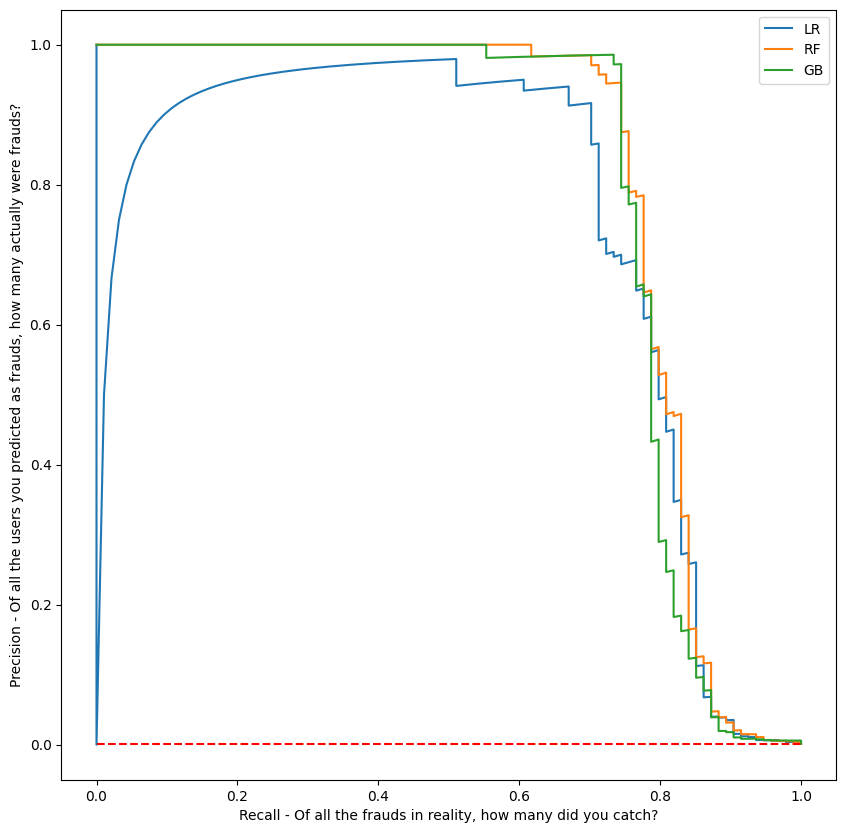

In [ ]:
# Lets visualize precision recall curve for all three models

plt.figure(figsize=(10,10))

# Logistic Regression
prec, rec, _ = precision_recall_curve(y_test, search_lr.predict_proba(X_test)[:, 1])
ap_lr_test = average_precision_score(y_test, search_lr.predict_proba(X_test)[:, 1])
plt.plot(rec, prec)

# Random Forest
prec, rec, _ = precision_recall_curve(y_test, search_rf.predict_proba(X_test)[:, 1])
ap_rf_test = average_precision_score(y_test, search_rf.predict_proba(X_test)[:, 1])
plt.plot(rec, prec)

# Gradient Boosting
prec, rec, _ = precision_recall_curve(y_test, search_gb.predict_proba(X_test)[:, 1])
ap_gb_test = average_precision_score(y_test, search_gb.predict_proba(X_test)[:, 1])
plt.plot(rec, prec)

plt.xlabel("Recall - Of all the frauds in reality, how many did you catch?")
plt.ylabel("Precision - Of all the users you predicted as frauds, how many actually were frauds?")
plt.legend(["LR", "RF", "GB"])

# Print train/test AP
print("LR AP: Train {:.3f} || Test {:.3f}".format(search_lr.best_score_, ap_lr_test))
print("RF AP: Train {:.3f} || Test {:.3f}".format(search_rf.best_score_, ap_rf_test))
print("GB AP: Train {:.3f} || Test {:.3f}".format(search_gb.best_score_, ap_gb_test))
plt.hlines(y=0.001727, xmin=0, xmax=1, colors='red', linestyles='dashed', label='Baseline (random)')


# looks like the test is pretty different from what we´ve seen in train (not very good?)
# so here GB shows to be the best model; we can play with the threasholds and find optimal balance between precision and recall:


In [142]:
# Here I want to see if I settle for catching 90% of all frauds, how many legitimate users will be wrongly flagged
# I think the final decision could depend on company's budget for false positives vs missed frauds

# Set your target recall (e.g., catch 90% of all frauds)
target_recall = 0.8

# Get predicted probabilities
y_probs = search_gb.predict_proba(X_test)[:, 1]

# Get precision-recall-thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# Find the first index where recall >= target (excluding the last point)
valid_idx = np.where(recalls[:-1] >= target_recall)[0]

if len(valid_idx) > 0:
    idx = valid_idx[-1]  # Take the last one to get highest precision at target recall
    threshold = thresholds[idx]
    
    y_pred = (y_probs >= threshold).astype(int)

    cm_gb = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_gb)
    disp.plot(cmap='Blues')

    print(f"Threshold for ≥ {target_recall:.2f} recall: {threshold:.3f}")
    print(f"Recall:    {recalls[idx]:.3f}")
    print(f"Precision: {precisions[idx]:.3f}")
    
    # Business impact analysis
    tn, fp, fn, tp = cm_gb.ravel()
    total_frauds = tp + fn
    total_legitimate = tn + fp
    
    print(f"\nBusiness Impact:")
    print(f"Total frauds in test set: {total_frauds}")
    print(f"Frauds caught: {tp} ({tp/total_frauds:.1%})")
    print(f"Frauds missed: {fn} ({fn/total_frauds:.1%})")
    print(f"Legitimate users flagged: {fp} ({fp/total_legitimate:.2%} of all legitimate users)")
    print(f"Legitimate users correctly cleared: {tn}")
    
else:
    print(f"No threshold found with recall ≥ {target_recall}")

ValueError: X has 28 features, but GradientBoostingClassifier is expecting 26 features as input.

Threshold for ≥ 0.90 precision: 0.938
Precision: 0.909
Recall:    0.745


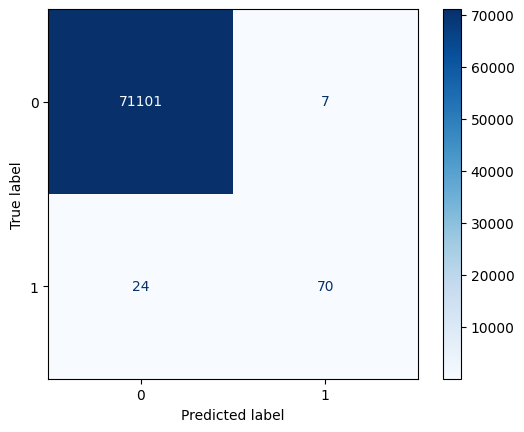

In [53]:

# Here I want to see if I settle for getting 60% of predicted fraud right; how many users will be actually hit wrongly and how many fraudsters we willl miss
# I think the final desicion could depend on company´s budget for chargebacks  - I would propose missing 10% of fraudulent users (0.885 recall) and being wrong with 50% of predictions; 
# since these are not that many users in relation to our total population, we are not losing that much
# In exchange if we compromised on blocking wrong people (0.1 precision) the win is not that big (?), only 5 additional fraudulent users  or so caught 


# Set your target precision
target_precision = 0.9

# Get predicted probabilities
y_probs = search_gb.predict_proba(X_test)[:, 1]

# Get precision-recall-thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# Find the first index where precision >= target (excluding the last point)
valid_idx = np.where(precisions[:-1] >= target_precision)[0]

if len(valid_idx) > 0:
    idx = valid_idx[0]
    threshold = thresholds[idx]
    
    y_pred = (y_probs >= threshold).astype(int)

    cm_gb = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_gb)
    disp.plot(cmap='Blues')

    print(f"Threshold for ≥ {target_precision:.2f} precision: {threshold:.3f}")
    print(f"Precision: {precisions[idx]:.3f}")
    print(f"Recall:    {recalls[idx]:.3f}")
else:
    print(f"No threshold found with precision ≥ {target_precision}")


# Debug the models

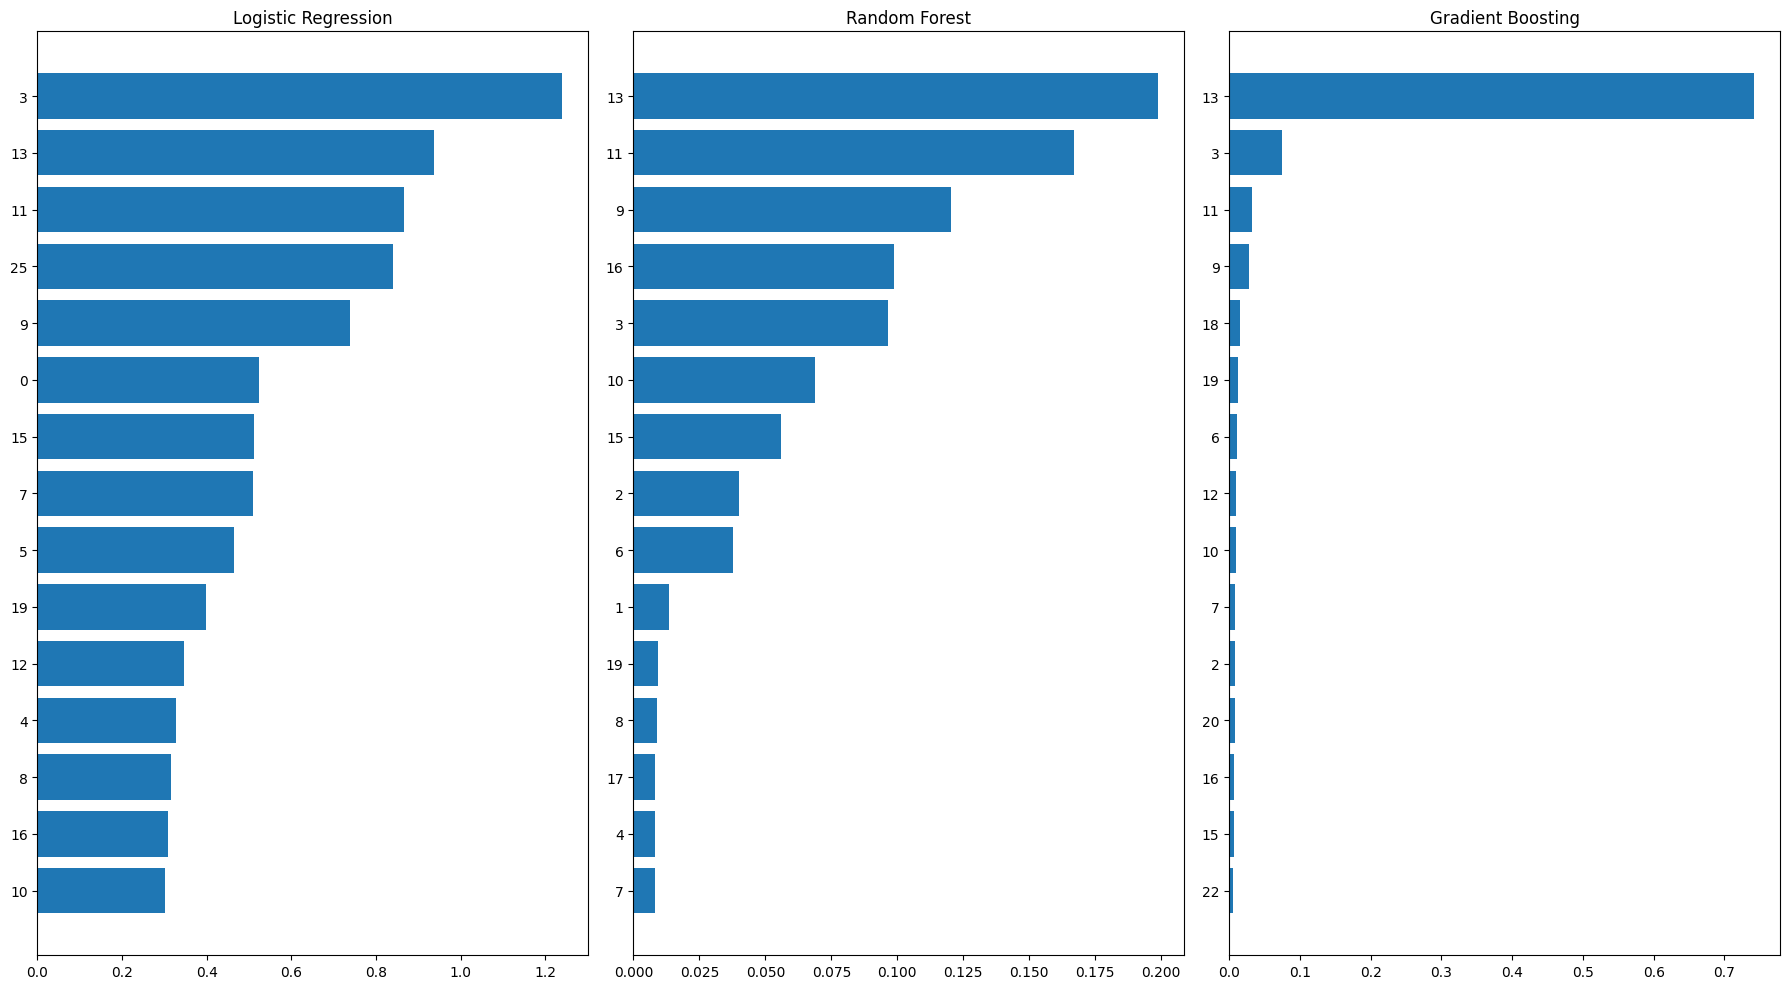

In [ ]:
# first lets check feature importance for all three models

lr_imp = np.abs(search_lr.best_estimator_['clf'].coef_).flatten()
rf_imp = search_rf.best_estimator_['clf'].feature_importances_
gb_imp = search_gb.best_estimator_['clf'].feature_importances_

# Helper to get sorted top N indices for a model
def top_features(imp, n=15):
    idx = np.argsort(imp)[-n:][::-1]
    return idx, imp[idx]

# Top 15 features for each model (sorted descending)
lr_idx, lr_vals = top_features(lr_imp)
rf_idx, rf_vals = top_features(rf_imp)
gb_idx, gb_vals = top_features(gb_imp)

# Plot
plt.figure(figsize=(18, 10))

plt.subplot(1, 3, 1)
plt.barh(range(15), lr_vals[::-1])
plt.yticks(range(15), lr_idx[::-1])
plt.title("Logistic Regression")

plt.subplot(1, 3, 2)
plt.barh(range(15), rf_vals[::-1])
plt.yticks(range(15), rf_idx[::-1])
plt.title("Random Forest")

plt.subplot(1, 3, 3)
plt.barh(range(15), gb_vals[::-1])
plt.yticks(range(15), gb_idx[::-1])
plt.title("Gradient Boosting")

plt.tight_layout()
plt.show()


# Note from heatmap:
## Features with highest positive corr to fraud are 2, 4, 11, 19
## Features with highest negative corr to fraud are 3, 9, 10, 12, 14, 17, 18, 20



# Notes on feature importance:
# Features 13 never appeares as correlated to Fraud in the heatmap but we are seeing it in the feature importance in all three models




In [60]:
# Predict labels (0/1) for each model
y_pred_lr = search_lr.predict(X_test)
y_pred_rf = search_rf.predict(X_test)
y_pred_gb = search_gb.predict(X_test)

# Collect row index for comparison
row_ids = X_test.index if hasattr(X_test, "index") else np.arange(len(X_test))

# Identify false positives and false negatives
fp_lr = row_ids[(y_pred_lr == 1) & (y_test == 0)]
fn_lr = row_ids[(y_pred_lr == 0) & (y_test == 1)]

fp_rf = row_ids[(y_pred_rf == 1) & (y_test == 0)]
fn_rf = row_ids[(y_pred_rf == 0) & (y_test == 1)]

fp_gb = row_ids[(y_pred_gb == 1) & (y_test == 0)]
fn_gb = row_ids[(y_pred_gb == 0) & (y_test == 1)]


In [61]:
# Overlaps in false positives
print("FP overlaps:")
print("LR & RF:", len(set(fp_lr).intersection(fp_rf)))
print("LR & GB:", len(set(fp_lr).intersection(fp_gb)))
print("RF & GB:", len(set(fp_rf).intersection(fp_gb)))

# Overlaps in false negatives
print("\nFN overlaps:")
print("LR & RF:", len(set(fn_lr).intersection(fn_rf)))
print("LR & GB:", len(set(fn_lr).intersection(fn_gb)))
print("RF & GB:", len(set(fn_rf).intersection(fn_gb)))


FP overlaps:
LR & RF: 75
LR & GB: 80
RF & GB: 47

FN overlaps:
LR & RF: 12
LR & GB: 12
RF & GB: 16


In [126]:
# lets add predictions from all three models to the test set to analize the errors

X_test_df = pd.DataFrame(X_test).reset_index(drop=True)

y_test_series = pd.Series(y_test, name="true_label").reset_index(drop=True)
y_pred_lr_series = pd.Series(y_pred_lr, name="pred_lr")
y_pred_rf_series = pd.Series(y_pred_rf, name="pred_rf")
y_pred_gb_series = pd.Series(y_pred_gb, name="pred_gb")

df_all_preds = pd.concat([
    X_test_df,
    y_test_series,
    y_pred_lr_series,
    y_pred_rf_series,
    y_pred_gb_series
], axis=1)

df_all_preds.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,true_label,pred_lr,pred_rf,pred_gb
0,1.166211,-1.039372,-0.197021,-1.182509,-1.213835,0.082741,-1.426677,0.057258,-0.879810,1.455480,...,-0.805311,-1.063132,-0.508851,0.159442,-0.113493,-0.153654,0,1,0,0
1,-1.278490,-0.240998,-1.098160,0.561564,1.702900,-1.620741,1.250177,-0.648734,0.293988,-0.877847,...,-0.597659,1.158913,-0.658160,-0.003945,0.979804,-0.193867,0,0,0,0
2,1.181587,-0.980875,-1.149513,-1.459612,-0.100980,1.080162,-1.156831,0.360447,-1.183890,1.499880,...,-1.637240,-0.765041,-0.166067,0.104341,-0.230085,-0.282336,0,0,0,0
3,0.031211,0.473866,-0.527896,-0.952129,0.565789,0.145630,0.618088,0.036559,0.064360,-1.391667,...,-2.659551,-1.832425,1.705938,-0.207963,0.138991,-0.001246,0,0,0,0
4,1.162321,-0.532304,-1.464491,-0.708559,-0.050078,-0.590640,-0.130009,-0.151450,-0.558244,0.915652,...,1.191658,0.440767,-0.101016,-0.200547,-0.244571,-0.194028,0,0,0,0


### Deep Dive GB Results

In [128]:

def classify_error(row):
    if row['true_label'] == 1 and row['pred_gb'] == 1:
        return "TP"
    elif row['true_label'] == 0 and row['pred_gb'] == 1:
        return "FP"
    elif row['true_label'] == 1 and row['pred_gb'] == 0:
        return "FN"
    else:
        return "TN"

df_all_preds["error_type_gb"] = df_all_preds.apply(classify_error, axis=1)


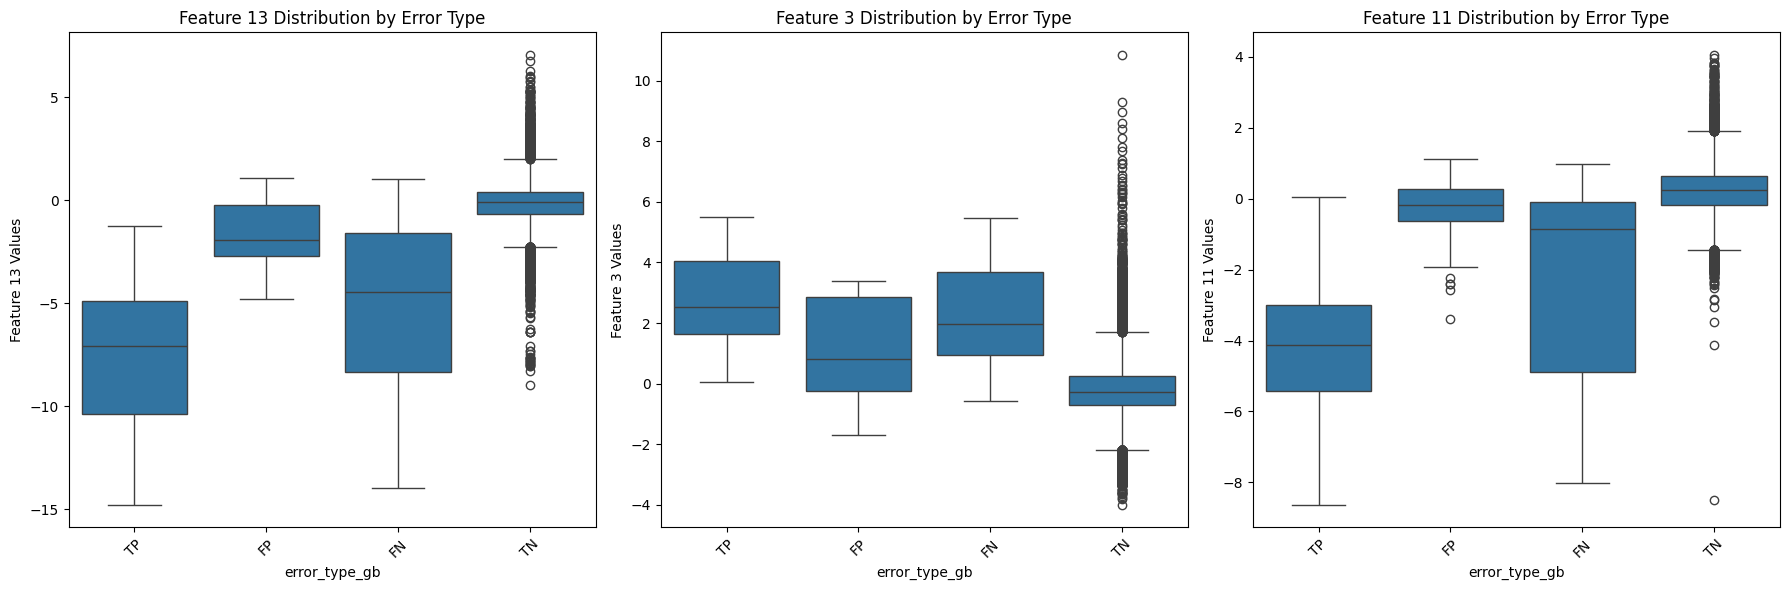

In [135]:
# Define features to plot
features_to_plot = [13, 3, 11]
feature_names = ["Feature 13", "Feature 3", "Feature 11"]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Loop through features
for i, (feature, name) in enumerate(zip(features_to_plot, feature_names)):
    sns.boxplot(data=df_all_preds, x="error_type_gb", y=feature, 
                order=["TP", "FP", "FN", "TN"], ax=axes[i])
    axes[i].set_title(f"{name} Distribution by Error Type")
    axes[i].set_ylabel(f"{name} Values")
    
    # Rotate x-axis labels if needed
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

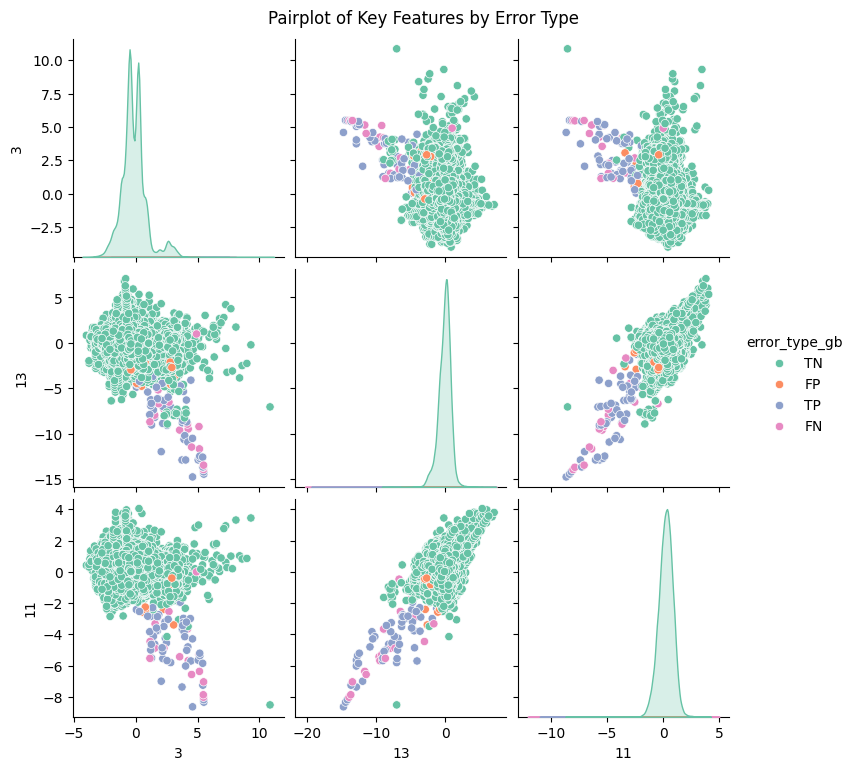

In [136]:
sns.pairplot(df_all_preds[[3, 13, 11, 'error_type_gb']], hue="error_type_gb", palette="Set2")
plt.suptitle("Pairplot of Key Features by Error Type", y=1.02)
plt.show()

In [137]:
# Do false negatives have tight or different values?
# Do false positives overlap with true positives?
# Is there a range where mistakes consistently happen?


df_all_preds[df_all_preds["error_type_gb"]=="FN"].describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
0,39.0,-0.47,1.32,-3.88,-1.17,-0.01,0.48,1.16
1,39.0,0.80,1.51,-5.14,0.10,0.84,1.84,3.07
2,39.0,-2.60,1.77,-6.20,-3.95,-2.26,-1.18,0.33
3,39.0,2.36,1.82,-0.58,0.94,1.96,3.67,5.48
4,39.0,0.65,1.67,-2.88,-0.21,0.63,1.14,7.30
5,39.0,-1.01,1.12,-4.42,-1.76,-0.92,-0.36,1.03
6,39.0,-1.05,2.01,-5.54,-2.53,-0.99,0.56,3.14
7,39.0,-0.36,2.38,-12.81,-0.37,-0.02,0.63,1.88
8,39.0,-1.25,1.38,-3.90,-2.18,-1.38,-0.15,1.52
9,39.0,-1.84,2.29,-6.86,-3.45,-1.34,-0.09,2.46


In [138]:
df_all_preds[df_all_preds["error_type_gb"]=="FP"].describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
0,108.0,0.22,1.15,-3.69,-0.32,0.81,1.03,1.21
1,108.0,0.21,0.80,-2.54,-0.21,0.35,0.68,2.30
2,108.0,-1.20,0.95,-4.57,-1.64,-1.30,-0.82,1.35
3,108.0,1.12,1.50,-1.71,-0.26,0.82,2.85,3.40
4,108.0,0.60,0.92,-2.95,0.20,0.62,0.89,3.07
5,108.0,-0.13,1.09,-1.99,-0.78,-0.39,0.25,3.29
6,108.0,0.27,1.12,-4.05,-0.01,0.24,0.62,3.03
7,108.0,0.01,0.63,-2.52,-0.25,-0.06,0.23,2.44
8,108.0,-0.44,0.84,-2.33,-1.07,-0.58,0.20,1.79
9,108.0,-0.20,1.04,-3.12,-0.65,0.04,0.28,3.61


### Review of overlapping errors

In [ ]:
# create dataframes for each error type that overlaps between different models

df_false_negatives = df_all_preds[(df_all_preds['true_label']==1) & 
             (df_all_preds['pred_lr']==0) &
            (df_all_preds['pred_rf']==0) & 
            (df_all_preds['pred_gb']==0)]

df_false_positives = df_all_preds[(df_all_preds['true_label']==0) & 
             (df_all_preds['pred_lr']==1) &
            (df_all_preds['pred_rf']==1) & 
            (df_all_preds['pred_gb']==1)]

df_true_positives = df_all_preds[(df_all_preds['true_label']==1) & 
             (df_all_preds['pred_lr']==1) &
            (df_all_preds['pred_rf']==1) & 
            (df_all_preds['pred_gb']==1)]


df_true_negatives = df_all_preds[(df_all_preds['true_label']==0) & 
             (df_all_preds['pred_lr']==0) &
            (df_all_preds['pred_rf']==0) & 
            (df_all_preds['pred_gb']==0)]

In [71]:
df_false_positives.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,46.0,2.220987,0.276465,1.742295,1.992226,2.281912,2.471221,2.635565
1,46.0,0.282521,1.216930,-3.694960,-0.123662,0.869033,1.011026,1.041995
2,46.0,0.625443,0.701071,-1.370462,0.370002,0.639069,0.713493,2.295912
3,46.0,-1.632172,0.894050,-4.565206,-1.854705,-1.427500,-1.234449,0.438127
4,46.0,2.352833,1.049225,-0.205462,2.246452,2.849526,2.909231,4.224780
5,46.0,0.604633,1.136770,-2.952608,0.403088,0.746478,0.958756,2.666300
6,46.0,-0.486342,0.709783,-1.986026,-1.009246,-0.388203,-0.131183,1.957789
7,46.0,0.363365,1.357868,-4.051915,0.186809,0.316233,0.779558,2.687939
8,46.0,0.056143,0.590777,-0.636660,-0.173240,-0.036809,0.072628,2.436153
9,46.0,-1.046147,0.568429,-2.633240,-1.263878,-1.066549,-0.778495,0.597561


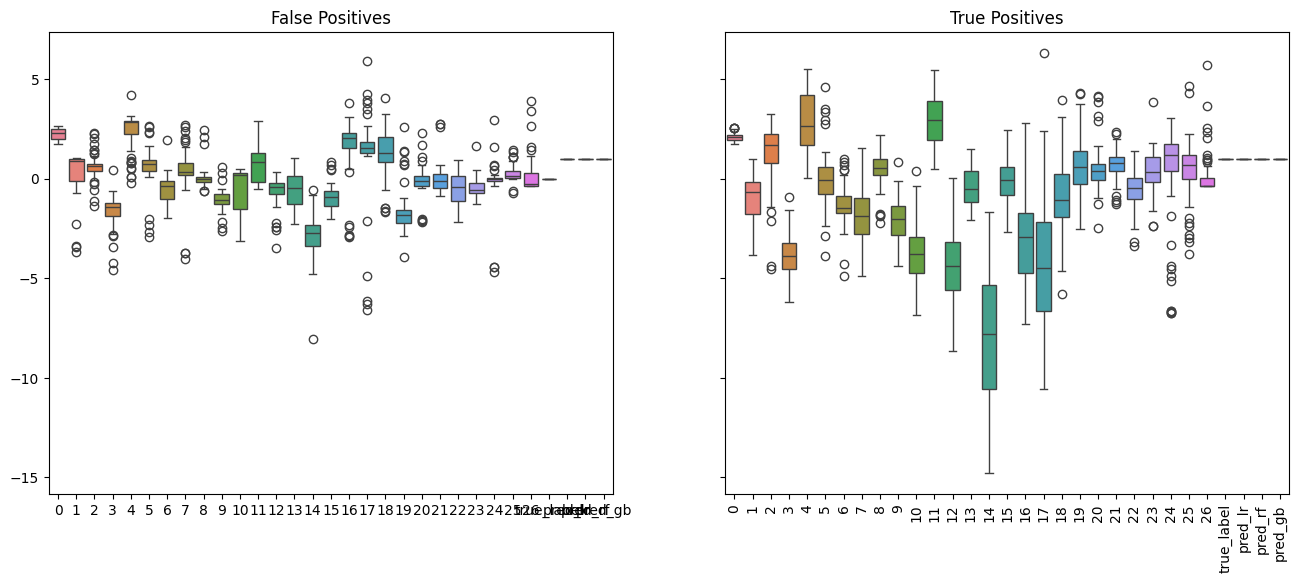

In [ ]:
# Among TP, certain features have huge variability

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

sns.boxplot(data=df_false_positives, ax=axes[0])
axes[0].set_title("False Positives")

sns.boxplot(data=df_true_positives, ax=axes[1])
axes[1].set_title("True Positives")


plt.xticks(rotation=90)
plt.show()

# Trying Ensemble Models

In [ ]:
voting_hard = VotingClassifier(
    estimators=[
        ('lr', search_lr.best_estimator_),
        ('rf', search_rf.best_estimator_),
        ('gb', search_gb.best_estimator_)
    ],
    voting='hard'
)

voting_hard.fit(X_train, y_train)
y_pred_hard = voting_hard.predict(X_test)


In [80]:
voting_soft = VotingClassifier(
    estimators=[
        ('lr', search_lr.best_estimator_),
        ('rf', search_rf.best_estimator_),
        ('gb', search_gb.best_estimator_)
    ],
    voting='soft',
    weights=[1, 1, 2]  # optional: boost best model
)

voting_soft.fit(X_train, y_train)
y_prob_soft = voting_soft.predict_proba(X_test)[:, 1]
y_pred_soft = (y_prob_soft > 0.5).astype(int)  # set your own threshold


In [ ]:
stacked = StackingClassifier(
    estimators=[
        ('lr', search_lr.best_estimator_),
        ('rf', search_rf.best_estimator_),
        ('gb', search_gb.best_estimator_)
    ],
    final_estimator=LogisticRegression(),
    passthrough=True  # includes original features
)

stacked.fit(X_train, y_train)
y_pred_stacked = stacked.predict(X_test)


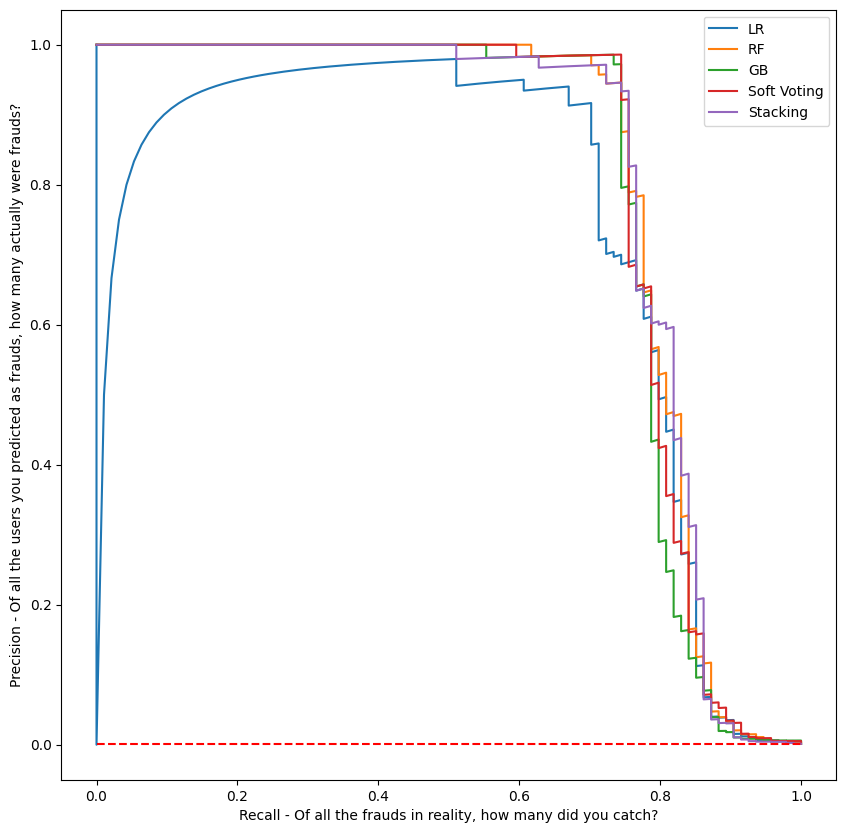

In [82]:
plt.figure(figsize=(10, 10))

# Logistic Regression
prec, rec, _ = precision_recall_curve(y_test, search_lr.predict_proba(X_test)[:, 1])
ap_lr_test = average_precision_score(y_test, search_lr.predict_proba(X_test)[:, 1])
plt.plot(rec, prec)

# Random Forest
prec, rec, _ = precision_recall_curve(y_test, search_rf.predict_proba(X_test)[:, 1])
ap_rf_test = average_precision_score(y_test, search_rf.predict_proba(X_test)[:, 1])
plt.plot(rec, prec)

# Gradient Boosting
prec, rec, _ = precision_recall_curve(y_test, search_gb.predict_proba(X_test)[:, 1])
ap_gb_test = average_precision_score(y_test, search_gb.predict_proba(X_test)[:, 1])
plt.plot(rec, prec)

# Soft Voting
prec, rec, _ = precision_recall_curve(y_test, voting_soft.predict_proba(X_test)[:, 1])
ap_soft_test = average_precision_score(y_test, voting_soft.predict_proba(X_test)[:, 1])
plt.plot(rec, prec)

# Stacking
prec, rec, _ = precision_recall_curve(y_test, stacked.predict_proba(X_test)[:, 1])
ap_stack_test = average_precision_score(y_test, stacked.predict_proba(X_test)[:, 1])
plt.plot(rec, prec)

plt.xlabel("Recall - Of all the frauds in reality, how many did you catch?")
plt.ylabel("Precision - Of all the users you predicted as frauds, how many actually were frauds?")
plt.legend(["LR", "RF", "GB", "Soft Voting", "Stacking"])
plt.hlines(y=0.001727, xmin=0, xmax=1, colors='red', linestyles='dashed', label='Baseline (random)')


In [83]:
print("LR AP: Test {:.3f}".format(ap_lr_test))
print("RF AP: Test {:.3f}".format(ap_rf_test))
print("GB AP: Test {:.3f}".format(ap_gb_test))
print("Soft Voting AP: Test {:.3f}".format(ap_soft_test))
print("Stacking AP: Test {:.3f}".format(ap_stack_test))


LR AP: Test 0.743
RF AP: Test 0.806
GB AP: Test 0.791
Soft Voting AP: Test 0.800
Stacking AP: Test 0.807
